# Formula 1 Grand Prix result prediction

## This project is aimed towards predicting the future F1 GP winners based on the drivers, constructors or both 
### Things to keep in mind

Before begining the project we need to understand the history of F1 and the diffrent eras in which a certain driver or constructor dominated the whole grid. Here are some important eras of F1 after 2010.  

* 1994-2009 Schumacher (Scuderia Ferrari)
* 2007-2010 Alonso (Renault,Scuderia Ferrari)
* 2011-2013 Vettle (Redbull Racing)
* 2014-Present Hamilton (Mercedes-Benz)

F1 Constructors performance are largely dependent on the FIA techinical regulation for the season after the 2013 season new engine regulation were made (Hybrid era) Mercedes-Benz are most dominat team since followed bu Redbull Racing and Scuderia Ferrari. Rules are set to change for 2022 so whatever analysis made here will not apply for 2022 season and so far. only data after 2010 will be considered in the following analysis. 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
plt.style.use('seaborn')

In [12]:
results = pd.read_csv(r'data\results.csv')
races = pd.read_csv(r'data\races.csv')
quali = pd.read_csv(r'data\qualifying.csv')
drivers = pd.read_csv(r'data\drivers.csv')
constructors = pd.read_csv(r'data\constructors.csv')
circuit = pd.read_csv(r'data\circuits.csv')

In [13]:
df1 = pd.merge(races,results,how='inner',on=['raceId'])
df2 = pd.merge(df1,quali,how='inner',on=['raceId','driverId','constructorId'])
df3 = pd.merge(df2,drivers,how='inner',on=['driverId'])
df4 = pd.merge(df3,constructors,how='inner',on=['constructorId'])
df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'])

In [15]:
#drop the columns which are not important
data = df5.drop(['round','circuitId','time_x','url_x','resultId','driverId',
                 'constructorId','number_x','positionText','position_x',
                 'positionOrder','laps','time_y','milliseconds','rank',
                 'fastestLapTime','fastestLapSpeed','qualifyId','q1',
                 'q2','q3','driverRef','number','code','url_y','circuitRef',
                 'location','lat','lng','alt','number_y','points','constructorRef','name_x','raceId','fastestLap'],1)


## F1 Grand Prix structure

a F1 GP runs for 3 days in the weeekend and is made of 3 parts Practice session, Qualify scession and the actual Race.

In the practice sesssion there are 3 stages FP1, FP2 and FP3 this is a free practice scession for teams to test their cars on Friday and saturday.
Qualification session is also made of 3 stages Q1, Q2 and Q3 in this session all drivers compete to set the best lap time and bottom 5 drivers will be eliminated after Q1. top 15 drivers will participate in the Q2 and try to set best lap time and top 10 drivers will move to Q1 where they again set best best lap time they can and the cars position at the start of the race will be decided based on their qualifying time driver with best time will get to start at the front.
Sunday scession is the Race and points will be awarded to top 10 drivers and top three will get to enjoy podium.
This happens for a full season for a whole year at diffrent circuits and driver with the highest points will be awarded World championship and team with highest points will get Constructorschampionship(each team have two cars and two drivers)

In [16]:
#considering data points from 2010
data = data[data['year']>=2010]

In [17]:
#rename the columns
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

In [18]:
#creating a driver age parameter
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

In [19]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [20]:
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [21]:
#reasons for DNF(did not finish)
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)
data.drop(['forename','surname'],1,inplace=True)

In [22]:
font = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':10
}

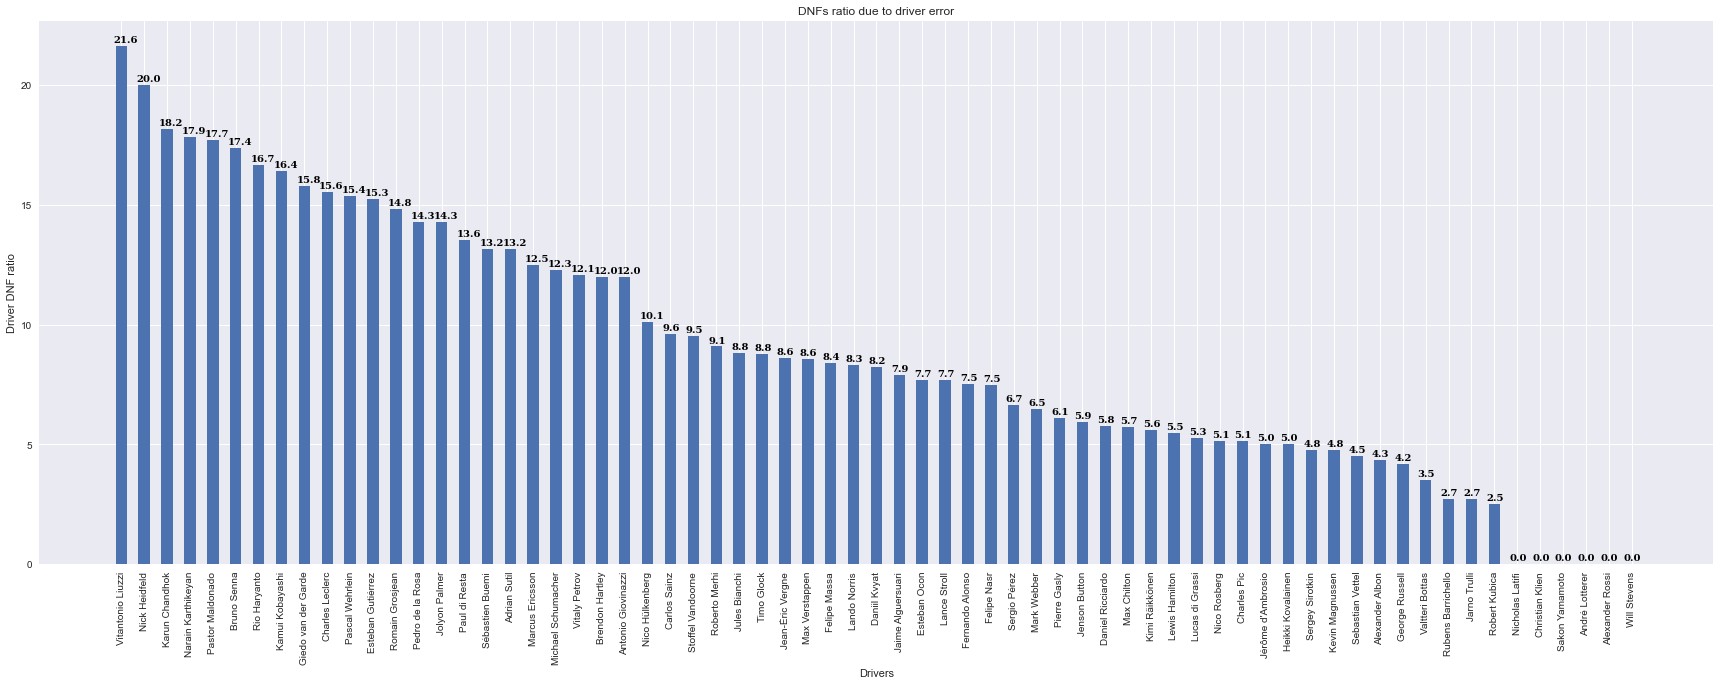

In [23]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver*100/driver_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('Driver DNF ratio')
plt.title('DNFs ratio due to driver error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1,yval+0.15,f'{round(yval,1)}',fontdict=font)
plt.show()

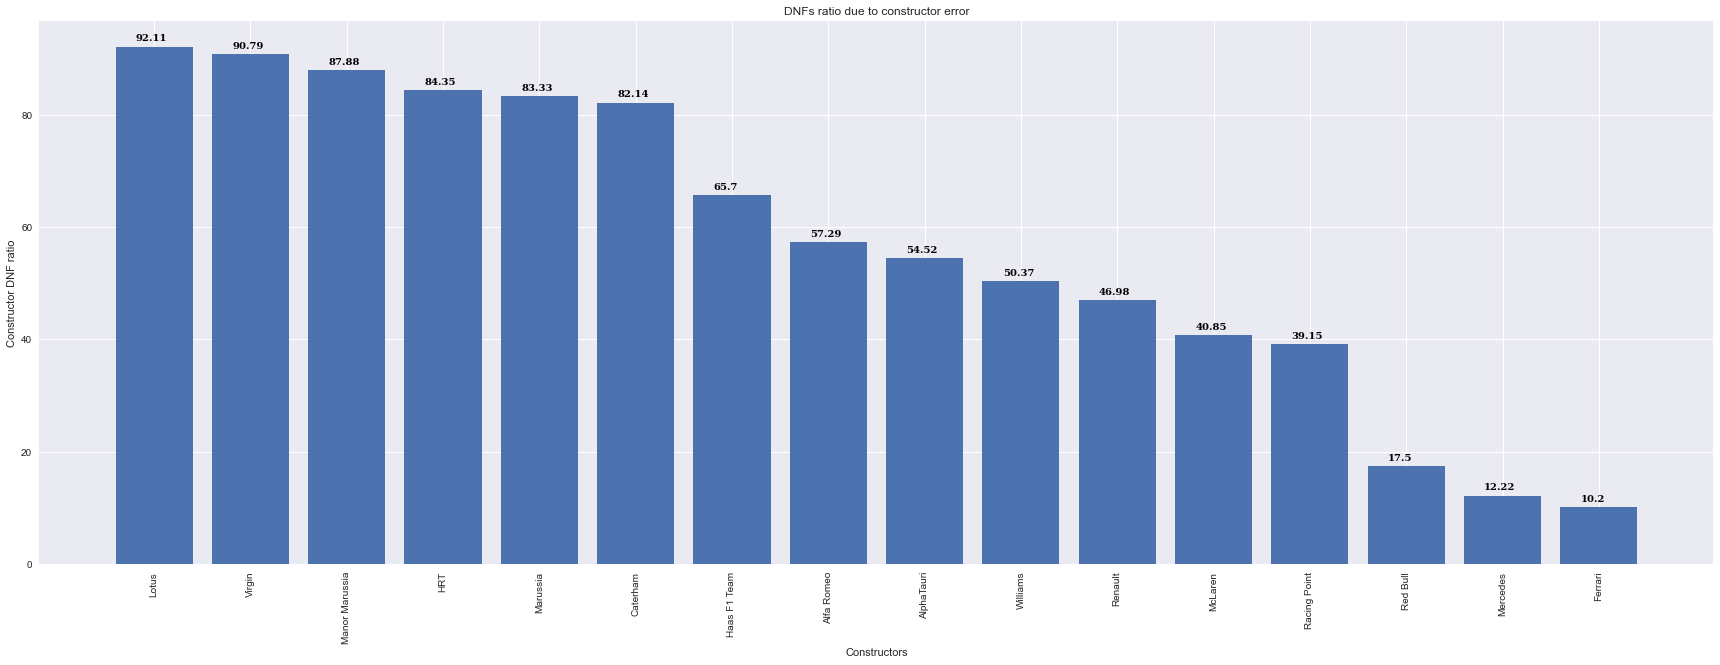

In [24]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor*100/constructor_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_dnf_ratio.index,height=constructor_dnf_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('Constructor DNF ratio')
plt.title('DNFs ratio due to constructor error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.21,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

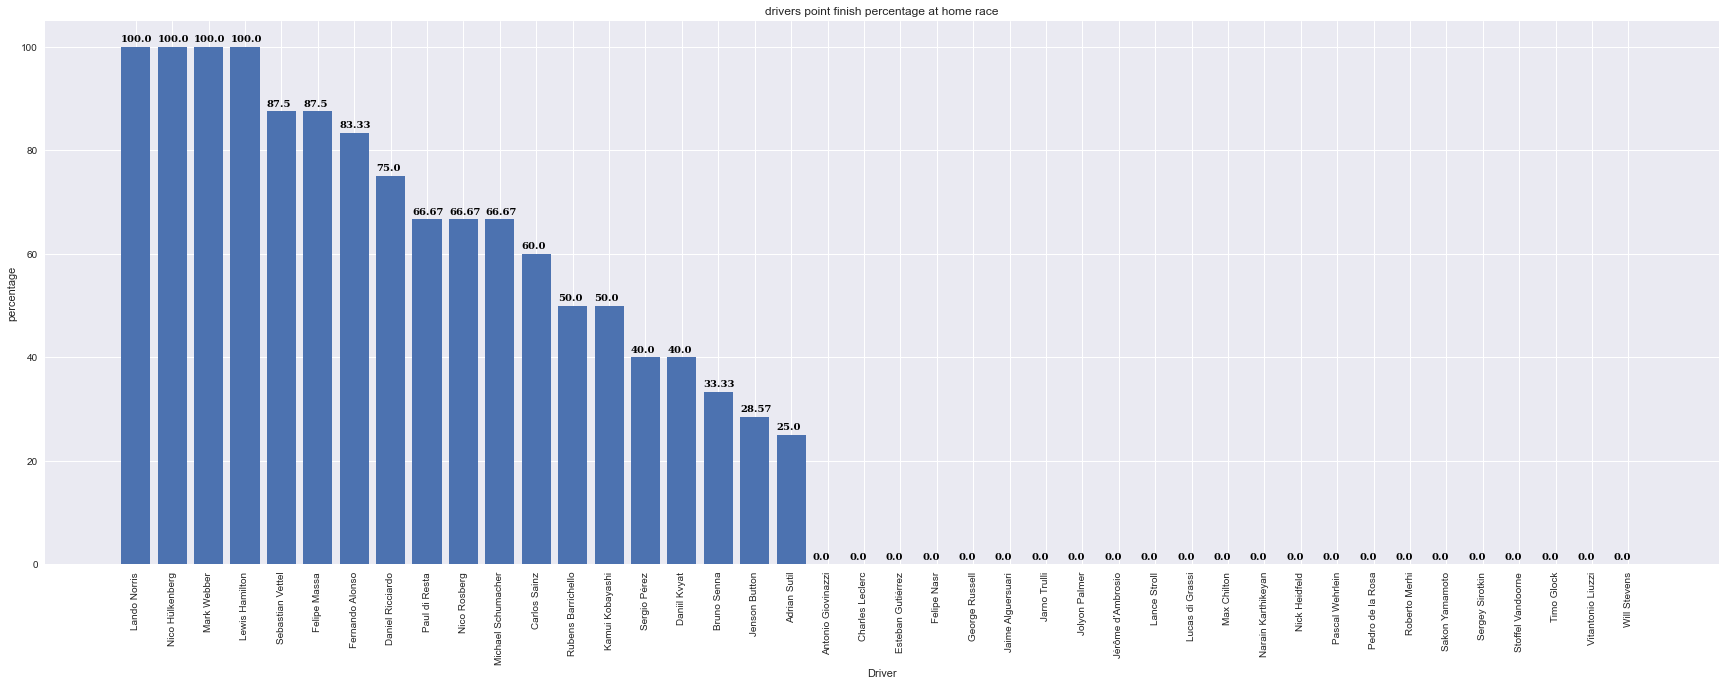

In [25]:
driver_home_points_finish = data.loc[(data['position']<11)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_point_finish_ratio = (driver_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_point_finish_ratio.index,height=driver_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Driver')
plt.ylabel('percentage')
plt.title('drivers point finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

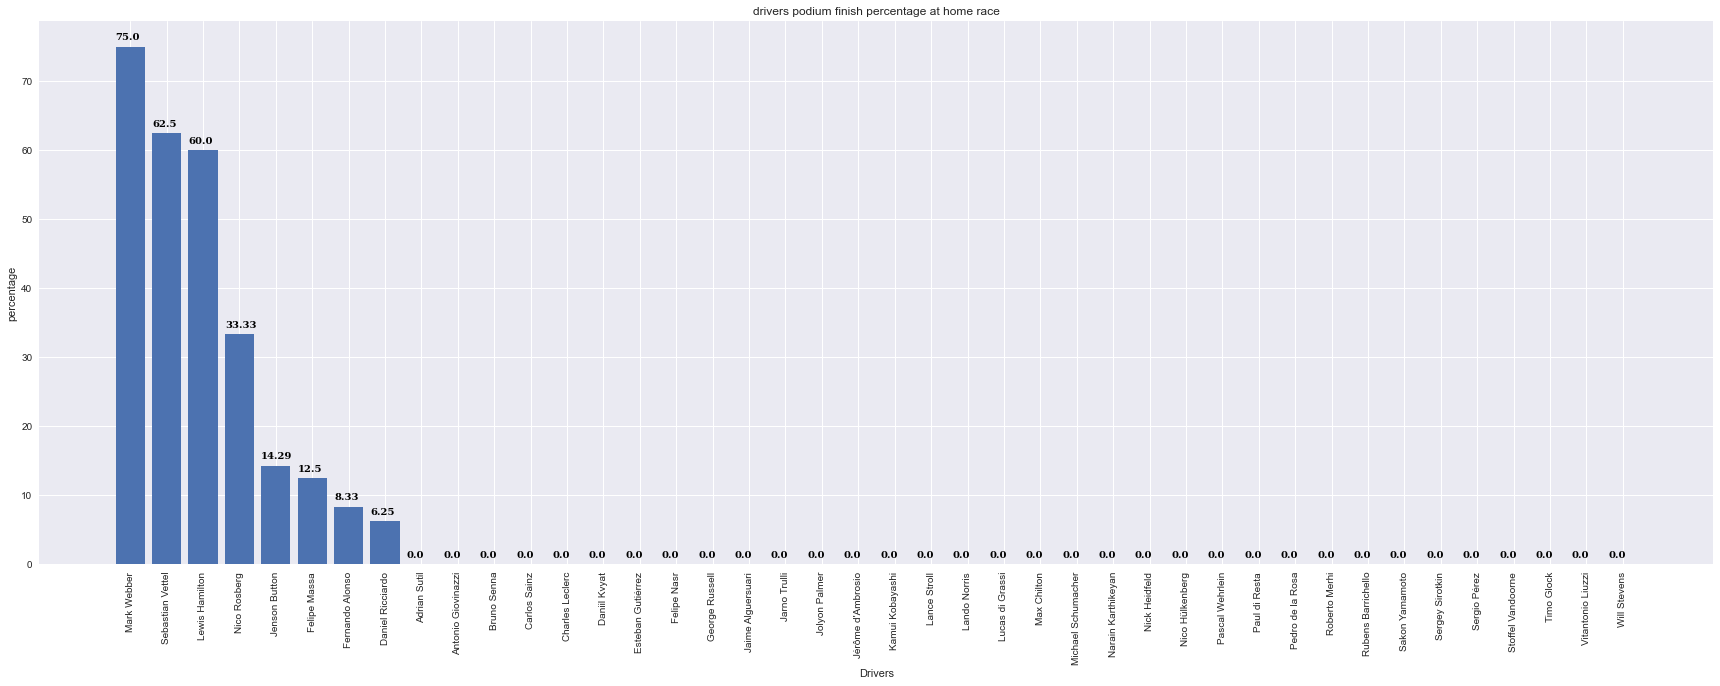

In [26]:
driver_home_podium_finish = data.loc[(data['position']<4)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_podium_finish_ratio = (driver_home_podium_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_podium_finish_ratio.index,height=driver_home_podium_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('percentage')
plt.title('drivers podium finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

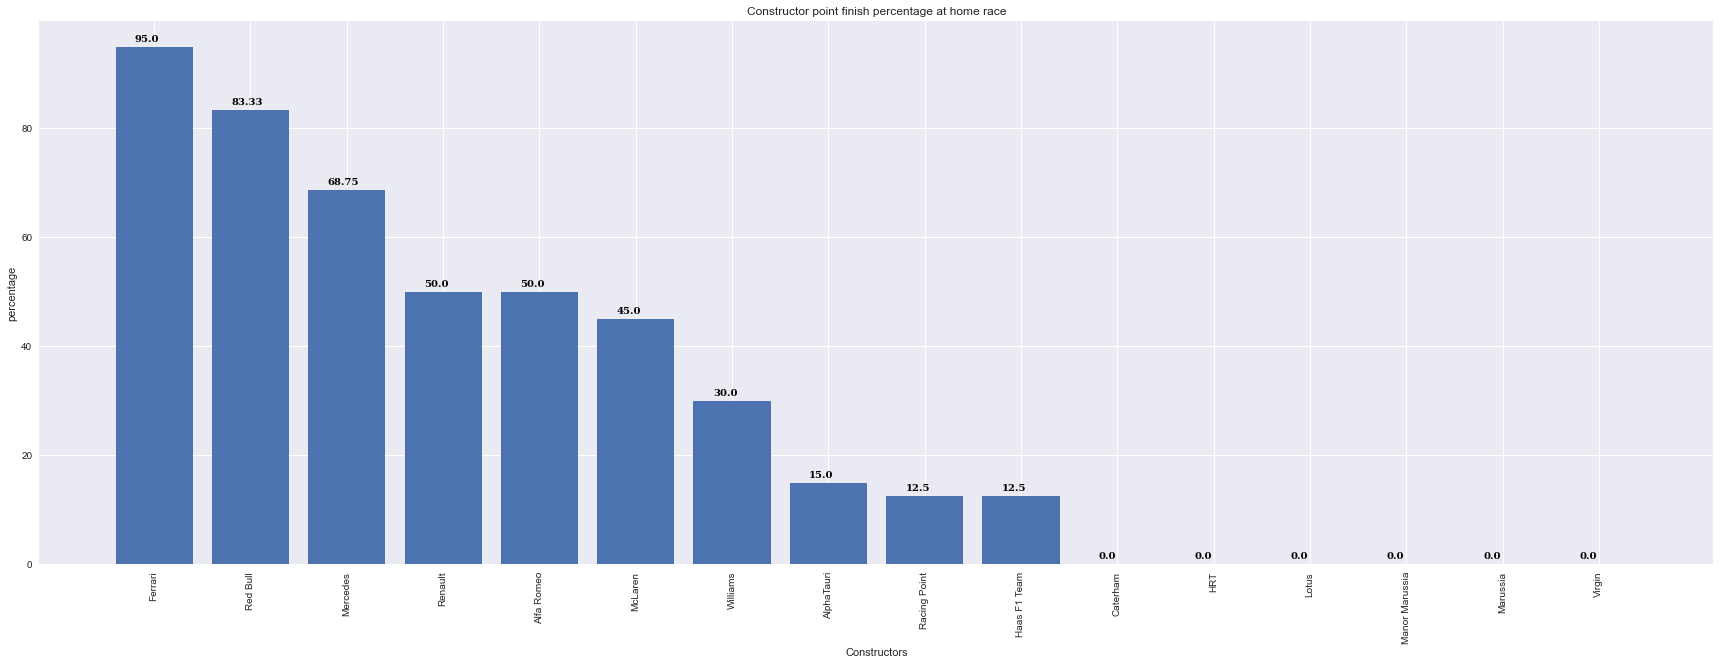

In [27]:
constructor_home_points_finish = data.loc[(data['position']<11)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('percentage')
plt.title('Constructor point finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

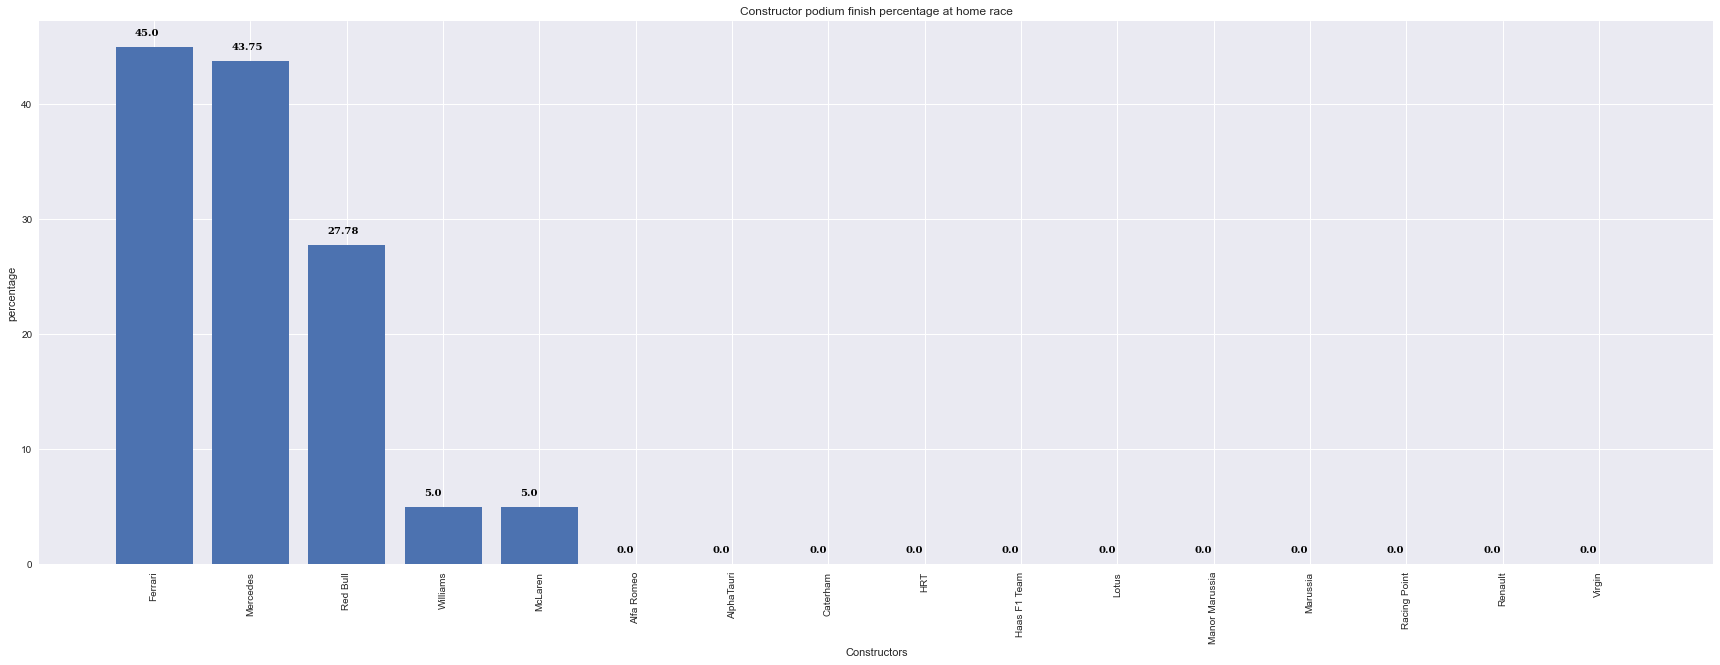

In [28]:
constructor_home_points_finish = data.loc[(data['position']<4)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('percentage')
plt.title('Constructor podium finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

In [29]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

In [30]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_relaiblity = 1-constructor_dnf_ratio
constructor_relaiblity_dict = dict(zip(constructor_relaiblity.index,constructor_relaiblity))

In [31]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_relaiblity'] = data['constructor'].apply(lambda x:constructor_relaiblity_dict[x])
#removing retired drivers and constructors
active_constructors = ['Renault', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Racing Point', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Daniil Kvyat',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Romain Grosjean','Nicholas Latifi']
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

### Model considering both drivers and constructors

In [32]:
cleaned_data = data[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_relaiblity','active_driver','active_constructor','dob']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
cleaned_data.to_csv('cleaned_data.csv',index=False)

In [33]:
x = cleaned_data.drop(['dob'],1)
x = x[(x['active_driver']==1)&(x['active_constructor']==1)]

In [34]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [35]:
sc  = StandardScaler()
le = LabelEncoder()
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
X = x.drop(['position','active_driver','active_constructor'],1)
y = x['position'].apply(lambda x: position_index(x))

In [36]:
#cross validation for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1)
    result = cross_val_score(model,X,y,cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

LogisticRegression : 0.9078880613126079
DecisionTreeClassifier : 0.9047927461139895
RandomForestClassifier : 0.9245493307426598
SVC : 0.9214027417962003
GaussianNB : 0.8376727115716754
KNeighborsClassifier : 0.8818598877374784


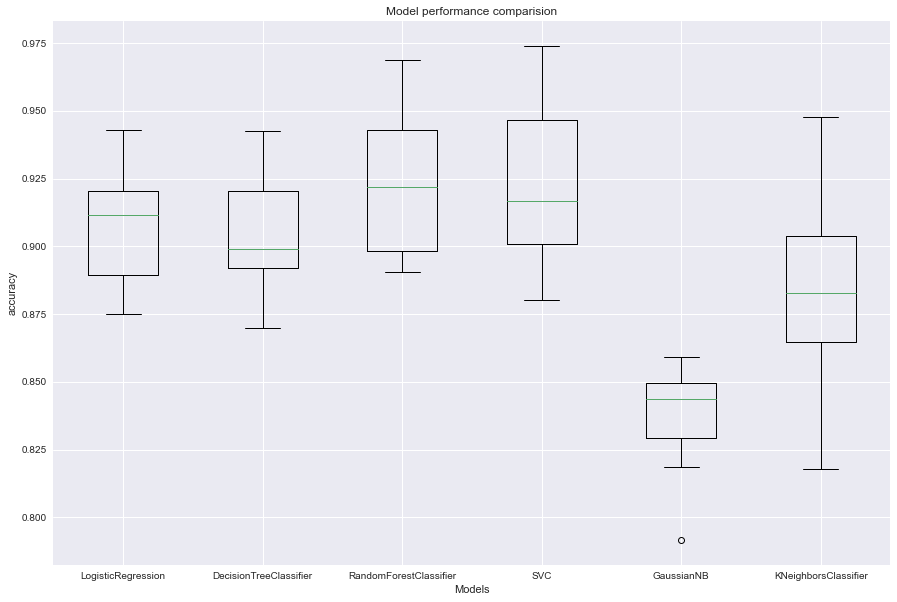

In [37]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision')
plt.show()

### Model considering only drivers

In [38]:
x_d= data[['GP_name','quali_pos','driver','age_at_gp_in_days','position','driver_confidence','active_driver']]

In [39]:
x_d = x_d[x_d['active_driver']==1]

In [40]:
sc  = StandardScaler()
le = LabelEncoder()
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['driver'] = le.fit_transform(x_d['driver'])
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['age_at_gp_in_days'] = sc.fit_transform(x_d[['age_at_gp_in_days']])
X_d = x_d.drop(['position','active_driver'],1)
y_d = x_d['position'].apply(lambda x: position_index(x))

In [ ]:
#cross validation for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results_dri = []
results_dri = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1)
    result = cross_val_score(model,X_d,y_d,cv=cv,scoring='accuracy')
    mean_results_dri.append(result.mean())
    results_dri.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

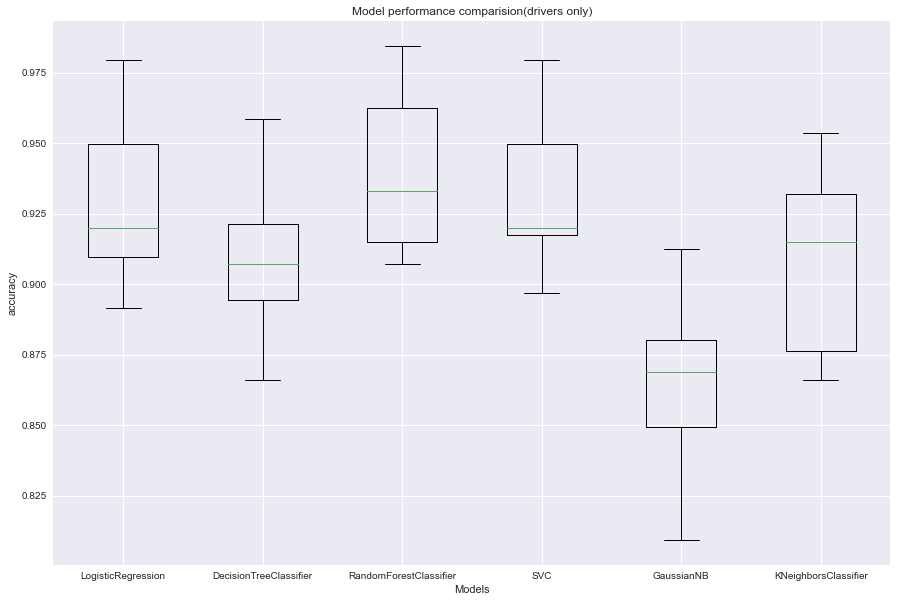

In [42]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results_dri,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision(drivers only)')
plt.show()

### Model considering only constructor

In [ ]:
x_c = data[['GP_name','quali_pos','constructor','position','constructor_relaiblity','active_constructor']]

In [44]:
x_c = x_c[x_c['active_constructor']==1]

In [45]:
sc  = StandardScaler()
le = LabelEncoder()
x_c['GP_name'] = le.fit_transform(x_c['GP_name'])
x_c['constructor'] = le.fit_transform(x_c['constructor'])
X_c = x_c.drop(['position','active_constructor'],1)
y_c = x_c['position'].apply(lambda x: position_index(x))

In [46]:
#cross validation for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results_const = []
results_const = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1)
    result = cross_val_score(model,X_c,y_c,cv=cv,scoring='accuracy')
    mean_results_const.append(result.mean())
    results_const.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

LogisticRegression : 0.9347480106100796
DecisionTreeClassifier : 0.9198938992042441
RandomForestClassifier : 0.9358090185676392
SVC : 0.9522546419098145
GaussianNB : 0.8665782493368699
KNeighborsClassifier : 0.930238726790451


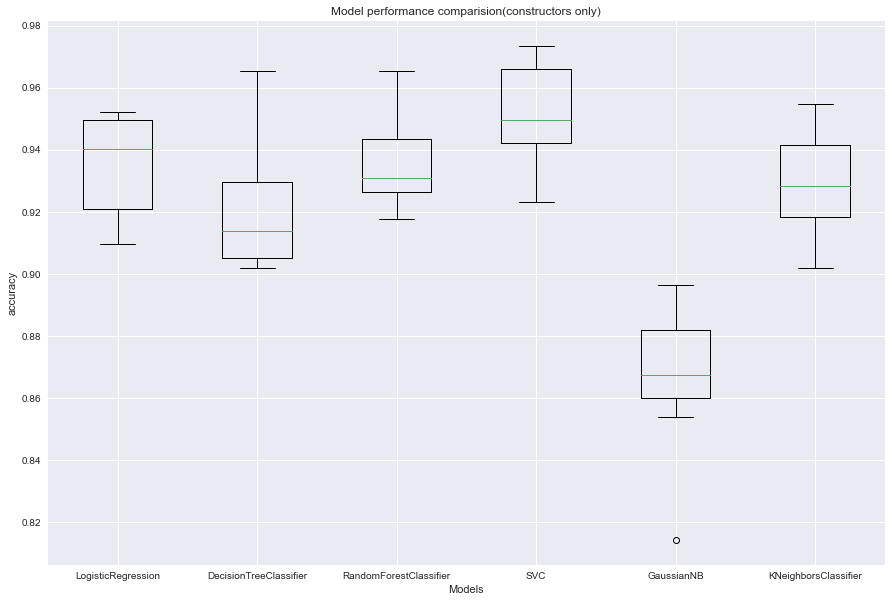

In [47]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results_const,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision(constructors only)')
plt.show()

#### lets see mean score of our three assumptions

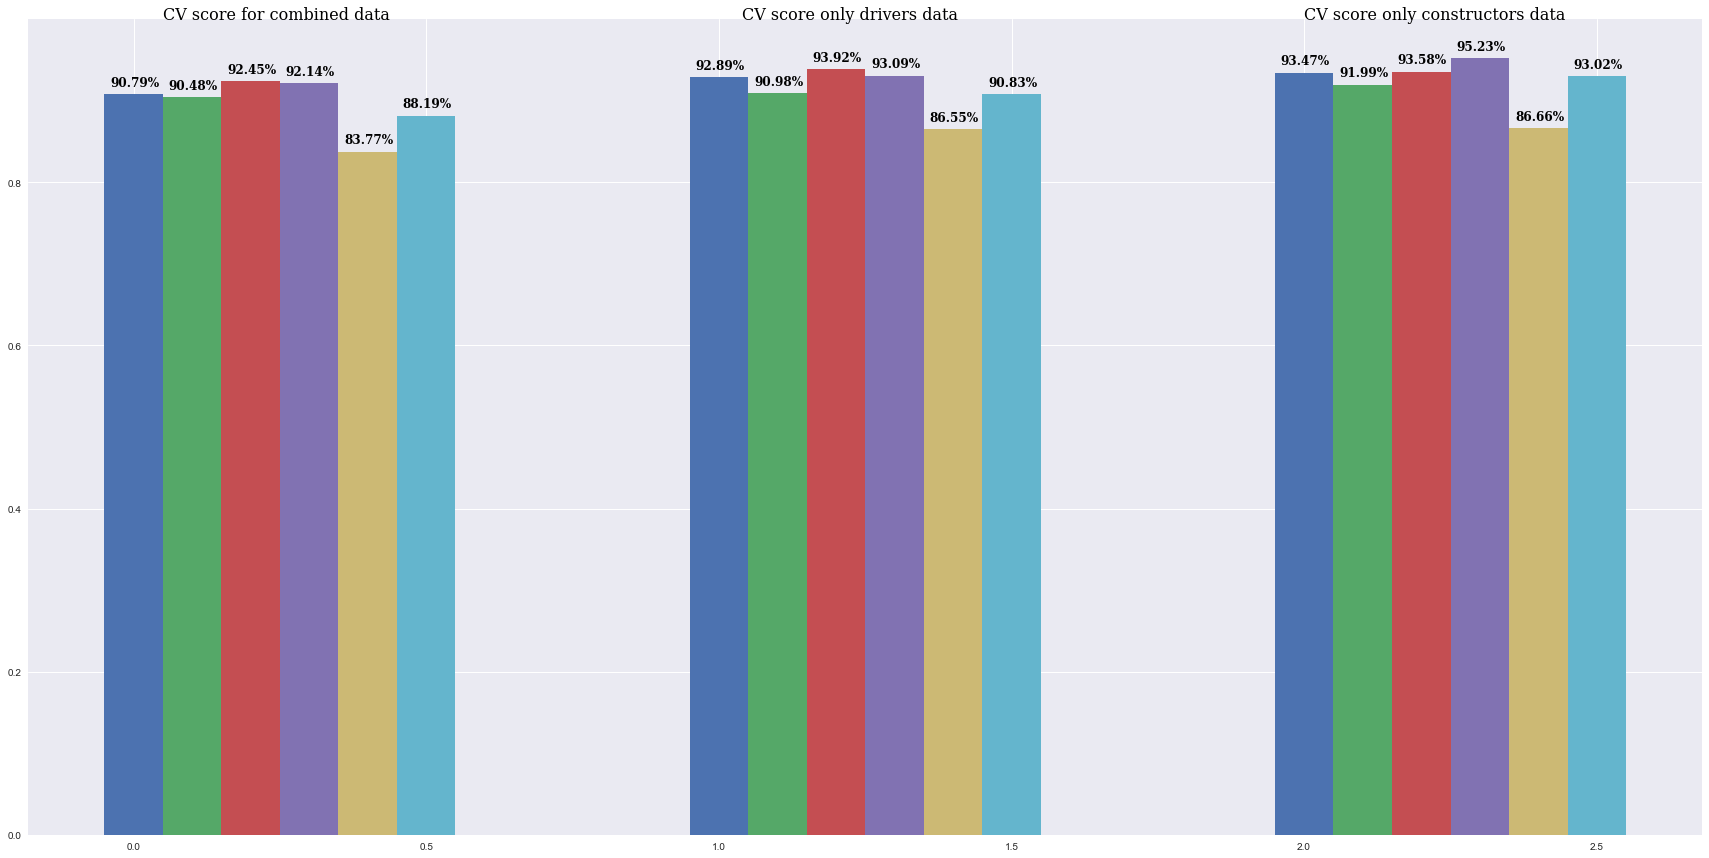

In [48]:
lr = [mean_results[0],mean_results_dri[0],mean_results_const[0]]
dtc = [mean_results[1],mean_results_dri[1],mean_results_const[1]]
rfc = [mean_results[2],mean_results_dri[2],mean_results_const[2]]
svc = [mean_results[3],mean_results_dri[3],mean_results_const[3]]
gnb = [mean_results[4],mean_results_dri[4],mean_results_const[4]]
knn = [mean_results[5],mean_results_dri[5],mean_results_const[5]]
font1 = {
    'family':'serif',
    'color':'black',
    'weight':'normal',
    'size':16
}
font2 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':12
}
x_ax = np.arange(3)
plt.figure(figsize=(30,15))
bar1 = plt.bar(x_ax,lr,width=0.1,align='center')
bar2 = plt.bar(x_ax+0.1,dtc,width=0.1,align='center')
bar3 = plt.bar(x_ax+0.2,rfc,width=0.1,align='center')
bar4 = plt.bar(x_ax+0.3,svc,width=0.1,align='center')
bar5 = plt.bar(x_ax+0.4,gnb,width=0.1,align='center')
bar6 = plt.bar(x_ax+0.5,knn,width=0.1,align='center')
plt.text(0.05,1,'CV score for combined data',fontdict=font1)
plt.text(1.04,1,'CV score only drivers data',fontdict=font1)
plt.text(2,1,'CV score only constructors data',fontdict=font1)
for bar in bar1.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar2.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar3.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar4.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar5.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar6.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
plt.show()

In [49]:
# n_estimators = [int(x) for x in np.linspace(start=200,stop=2000,num=10)]
# max_features = ['auto','sqrt']
# max_depth = [int(x) for x in np.linspace(10,110,num=11)]
# min_samples_split = [2,5,8,10,15,20]
# min_samples_leaf = [1,2,4,6,8,10]
# bootstrap = [True,False]

# random_parms = {
#     'n_estimators':n_estimators,
#     'max_features':max_features,
#     'max_depth':max_depth,
#     'min_samples_split':min_samples_split,
#     'min_samples_leaf':min_samples_leaf,
#     'bootstrap':bootstrap
#                 }

In [50]:
# rf_rand = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator=rf_rand,param_distributions=random_parms,n_iter=100,cv=10,verbose=2,n_jobs=-1)
# rf_random.fit(X,y)
# rf_random.best_params_

In [51]:
rf = RandomForestClassifier(n_estimators=1600,min_samples_split=20,min_samples_leaf=1,max_features='sqrt',max_depth=90,bootstrap=True)
kf = StratifiedKFold(n_splits=10,random_state=None,shuffle=False)
for train_index,test_index in kf.split(X,y):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]

In [52]:
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
cnf_mat_rf = confusion_matrix(y_test,y_pred_rf)
cnf_mat_rf = cnf_mat_rf/cnf_mat_rf.sum()

In [55]:
svc = SVC()
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)
cnf_mat_svc = confusion_matrix(y_test,y_pred)
cnf_mat_svc = cnf_mat_svc/cnf_mat_svc.sum()

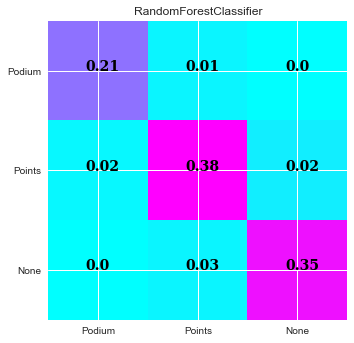

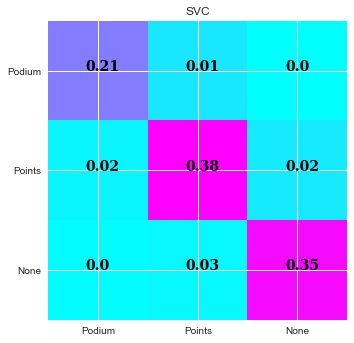

In [56]:
font3 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':14
}
fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
ax1.set_xticks(np.arange(3))
ax1.set_yticks(np.arange(3))
ax1.set_xticklabels(['Podium','Points','None'])
ax1.set_yticklabels(['Podium','Points','None'])
ax1.set_title('RandomForestClassifier')
im_rf = ax1.imshow(cnf_mat_rf,cmap='cool')
for i in range(3):
    for j in range(3):
            ax1.text(i-0.125,j,round(cnf_mat_rf[i,j],2),fontdict=font3)

ax2.set_xticks(np.arange(3))
ax2.set_yticks(np.arange(3))
ax2.set_xticklabels(['Podium','Points','None'])
ax2.set_yticklabels(['Podium','Points','None'])
ax2.set_title('SVC')
im_svc = ax2.imshow(cnf_mat_svc,cmap='cool')
for i in range(3):
    for j in range(3):
            ax2.text(i-0.125,j,round(cnf_mat_rf[i,j],2),fontdict=font3)

In [57]:
rf_pression = precision_score(y_test, y_pred_rf, average='macro')
rf_f1 = f1_score(y_test,y_pred_rf,average='macro')
rf_recall = recall_score(y_test,y_pred_rf,average='macro')
svc_pression = precision_score(y_test, y_pred_svc, average='micro')
svc_f1 = f1_score(y_test,y_pred_svc,average='macro')
svc_recall = recall_score(y_test,y_pred_svc,average='macro')
metrics_dict ={
    'RandomForestClassifier':{'precision_score':rf_pression,'f1_score':rf_f1,'recall_score':rf_recall},
    'SVC':{'precision_score':svc_pression,'f1_score':svc_f1,'recall_score':svc_recall}
}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,RandomForestClassifier,SVC
precision_score,0.935338,0.901042
f1_score,0.934012,0.896870
recall_score,0.932923,0.893476
